# Kerchunk Demo

demo with single hdf5 file.

It is possible to create a kerchunk mapping for multiple files allowing you to treat a collection of hdf5 files as a single zarr store.

I ran into some version issues previously, this is known to work with:
- fsspec v2023.3.0
- kerchunk v0.1.0
- zarr v2.13.6

## Just a little about kerchunk
- kerchunk takes an hdf5 file and creates a mapping that maps a single slice of an hdf5 file to a zarr store chunk
- this mapping is then able to be read by zarr and the handling of this is abstracted
- the mappings can take a while to compute, but can be precomputed and stored to disk for specific arrangements of the data
    - so for instance, if we uploaded all of the ooi DAS data, we could create different mappings for the different segments of the experiment and save those on the cloud as well

In [1]:
import fsspec
import kerchunk.hdf
import zarr

import xarray as xr
import dask
from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39235,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.80 GiB
Comm: tcp://127.0.0.1:40847,Total threads: 4
Dashboard: http://127.0.0.1:41559/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:45663,


In [3]:
# Set the account name, container name, and file path
account_name = "dasdata"
container_name = "hdf5"
file_path = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"

# Set the blob URL using the fsspec AzureBlobFileSystem
url = f"az://{container_name}/{file_path}"
openfile = fsspec.open(url, account_name=account_name)

In [4]:
# Generate dictionary
h5chunks = kerchunk.hdf.SingleHdf5ToZarr(openfile.open(), url)
out = h5chunks.translate()

In [5]:
storage_options = {
    'fo':out,
    'remote_protocol':'az',
    'remote_options':dict(account_name=account_name)
}

z = zarr.open("reference://", storage_options=storage_options)

In [6]:
# open the raw data as dask array and then read in with xarry
da = dask.array.from_zarr(z['Acquisition']['Raw[0]']['RawData'])
dax = xr.DataArray(da)

## Distributed Computing
- open http://127.0.0.1:8787/status
    - this will allow you to visualize the multithreading
- if you are on a vm, forward port 8787 to local machine
    - this can be done with vscode in the 'ports' pane of the terminal

In [14]:
dax_std = dax.std('dim_1')

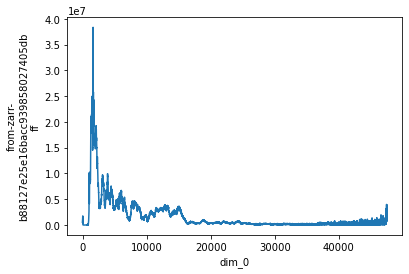

In [17]:
dax_std.compute().plot()

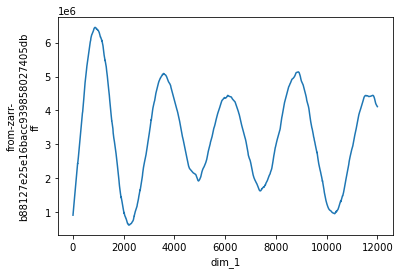

In [20]:
dax[10000,:].plot()